In [1]:
from torchvision.transforms import Compose, Normalize
from modules.model import AdaptivePoolTransform

transform = Normalize(mean=(0.0,), std=(1.0,))  # Assume Laplace distributed inputs are mean 0, std 1


In [2]:
from pl_modules import ReconstructKspaceDataModule
from modules.kspace_data import KspaceDataTransform
import pathlib as p
dm = ReconstructKspaceDataModule(
            p.Path("D:/knee_dataset"),
            challenge="singlecoil",
            train_transform=KspaceDataTransform(),
            val_transform=KspaceDataTransform(),
            test_transform=KspaceDataTransform(),
            model_transform=transform,
            batch_size=1,
            num_workers=8,
            use_dataset_cache_file=True)

c:\Users\sandr\source\repos\pixelcnn_experiment\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_set = dm.train_dataloader()

In [7]:
from modules.model import ZeroPaddingTransform
transform_1 = Compose([AdaptivePoolTransform((32,64), pool_type="avg"), transform])
another = Compose([ZeroPaddingTransform((45,45)), transform])
for batch in train_set:
    kspace = batch.kspace
    masked_kspace = batch.masked_kspace
    print(kspace.shape)
    print(transform_1(kspace).shape)
    print(another(kspace).shape)
    break

torch.Size([1, 2, 640, 372])
torch.Size([1, 2, 32, 64])
torch.Size([1, 2, 640, 372])


In [20]:
import yaml
with open("config.yaml", "r") as file:
    data = yaml.safe_load(file)["datamodule"]["kspace"]

print(data)

None


In [3]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_type = "random" # or equispaced
center_fractions = [0.08, 0.04]
accelerations = [4, 8]
mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
from modules.kspace_data import KspaceSample

s = KspaceSample(0,1)
s[0]

0

# Agenda to discuss
- different kspace shapes (for forward diffusion equal shape is required)
- output values (images: 256, because in paper they use softmax for probabilities)
- split real and imaginary channel?
- full kspace to full kspace, noisy kspace to full kspace, undersampled kspace to full kspace 
- different masking, 1D convolutions, multiplications instead of convolutions

In [86]:
import numpy as np
samples = None
for i, sample in enumerate(dataloader):
    point = sample.masked_kspace[:,:,:,0].numpy().ravel()
    if i>0:
        samples = np.append(samples, point)
    else:
        samples = point
    if i >= 300:
        print(i)
        break
print(samples.shape)

300
(71293440,)


In [87]:
print(len(set(samples.tolist())))

10873542


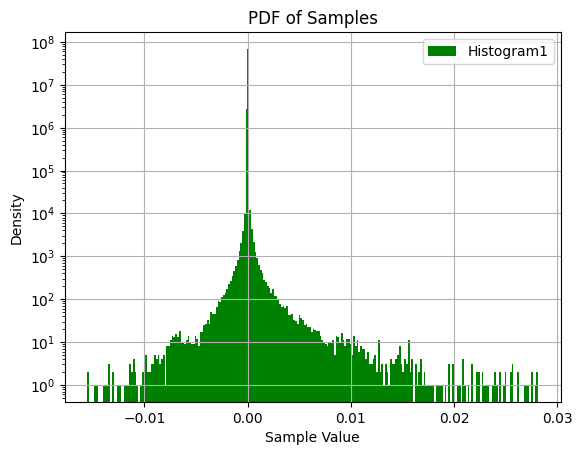

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Step 1: Generate or load samples (example: normal distribution)
# samples = np.random.normal(loc=0, scale=1, size=(1000,))  # 1000 samples from N(0, 1)
# print(samples.shape)

# Step 2a: Estimate PDF using a histogram
# plt.hist([samples[:235520], samples[235520:2*235520]], bins=256, density=False, color=['g','b'], label=['Histogram1', 'Histogram2'], log=True, stacked=True)
plt.hist(samples, bins=256, density=False, color='g', label='Histogram1', log=True)

# Step 2b: Estimate PDF using Kernel Density Estimation (KDE)
# kde = gaussian_kde(samples)
# x = np.linspace(min(samples), max(samples), samples.shape[0])  # Create a range for x values# pdf = kde(x)  # Evaluate the KDE at these points
# plt.plot(x, pdf, color='blue', label='KDE')

# Step 3: Customize and display the plot
plt.title('PDF of Samples')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [70]:
import h5py
import os
from fastmri.data import transforms as T
mi = 0
ma = 0
path = "knee_singlecoil_val/singlecoil_val"
for file in os.listdir(path):
    hf = h5py.File(os.path.join(path,file))
    kspace =T.to_tensor(hf["kspace"][()])
    if kspace.min() < mi:
        mi = kspace.min()
    if kspace.max() > ma:
        ma = kspace.max()
print("Max: ", ma)
print("Min: ", mi)

Max:  tensor(0.0618)
Min:  tensor(-0.0298)
